In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae
import weapon_data as weapons

from tensorflow.python.framework import random_seed

import matplotlib.pyplot as plt
%matplotlib inline

class tfPlugin:
    def __init__(self):
        self._sess = None
        self._vae = None
        self.trained_model_save_folder = "trained_vae/"
        self.training_data_source = "training_data.csv"
        self.test_data_source = "test_data.csv"
        
    def onSetup(self):
        self._random_seed = 19071991
        seed, _ = random_seed.get_seed(self._random_seed)
        np.random.seed(seed)
        
        self.shouldStop = False
        
        self._train_data, self._test_data = weapons.get_data(self.training_data_source, self.test_data_source, seed=self._random_seed)

        #set training parameter
        self._network_architecture = \
            dict(n_input=self._train_data.num_features,
                 n_hidden_1=26,
                 n_hidden_2=12,
                 n_z=2)  
        self._batch_size = 4
        self._learning_rate = 0.01
        self._optimizer = tf.train.RMSPropOptimizer(self._learning_rate)
        self._transfer_fct = tf.nn.elu
        self._num_training_epochs = 100
        
        #keep track of the received and dismantled weapons 
        self._dismantled_weapons = []
        
        #amount of dismantles models needed to retrain the model
        self._dismantled_weapons_needed_to_retrain = 20
        
        #start session is realized in on begin training and will be swaped with the tmp afterwards
        self._sess = None
        self._vae = None
        
        self._trained_model_available = False
        self._trained_model_path = ""
        
    def onJsonInput(self, jsonInput):
        if self._trained_model_available:
            self.__load_trained_model()
            
        if self._vae == None:
            print("ERROR: there is no trained model?!")
            return {}
        
        if not bool(jsonInput):
            print("ERROR: empty input!")
            return {}
        
        generated_weapon = []
        
        #encode the json input to a standardized weapon data
        encoded_json_input = self.__encode_json_input_to_a_standardized_train_data_format(jsonInput)
        #check if the encoded data should be used to generate a new one 
        #calculate loss requires a batch which has the size of the trained model batch_size
        batch = [encoded_json_input[0] for _ in range(self._batch_size)]
        generation_cost = self._vae.calculate_loss(batch)
        generation_cost /= self._batch_size

        #if the cost is too high, then just generate a random one
        #a too high value means that the VAE don't know which weapon that should be!
        if generation_cost >= 50 or np.isnan(generation_cost) or np.isinf(generation_cost):
            generated_weapon = self.__generate_random_weapons(1)
            print("Generated a random weapon!")
        else:
            generated_weapon = self._vae.encode_and_decode(encoded_json_input, False)
            print("Generated a new weapon based on a dismantled one!")

        if len(generated_weapon) <= 0:
            print("ERROR: no generated weapon?!")
            return {}
        
        #do it afterwards so that crazy weapons don't destroy the model
        self.__add_received_dismantled_weapon(encoded_json_input[0])
        
        result, _ = self._train_data.decode_processed_tensor(generated_weapon[0])
        return result
        
    def onBeginTraining(self):
        with tf.Session() as sess:

            #add the dismantled weapons so that the model emerges in a direction
            if len(self._dismantled_weapons) > 0:
                self._train_data.add_new_weapons_and_restandardize_data(self._dismantled_weapons)
                self._dismantled_weapons = []
                self._num_training_epochs += 10

            network = vae.get_untrained(sess, self._network_architecture, self._optimizer, 
                                      self._transfer_fct, self._batch_size)

            num_samples = self._train_data.num_examples
            print("Num of training samples = %i" %num_samples)
            
            #is basically the same code from the VAE file
            #training cycle
            for epoch in range(self._num_training_epochs):
                avg_cost = 0.
                total_batch = int(num_samples / self._batch_size)

                # Loop over all batches
                for _ in range(total_batch):
                    batch = self._train_data.next_batch(self._batch_size)

                    # Fit training using batch data
                    cost = network.train_with_mini_batch(batch)

                    #compute average loss/cost
                    avg_cost += cost / num_samples * self._batch_size

                # Display logs per epoch step
                if (epoch+1) % 10 == 0:
                    print("Epoch:"+ '%04d' % (epoch+1) + " - Cost:" + "{:.2f}".format(avg_cost))

                if self.shouldStop:
                    break;

            self._trained_model_path = network.save_trained_model(self.trained_model_save_folder)
            self._trained_model_available = True
        
        
    def onStopTraining(self):
        if self._sess:
            self._sess.close()
        
    def __load_trained_model(self):
        if self._sess:
            self._sess.close()
        tf.reset_default_graph()
    
        self._sess = tf.Session(graph=tf.get_default_graph())
        self._vae = vae.get_untrained(self._sess, self._network_architecture, self._optimizer, 
                                  self._transfer_fct, self._batch_size)
        self._vae = vae.restore(self._vae, self._trained_model_path)
        self._trained_model_available = False
        
    def __encode_json_input_to_a_standardized_train_data_format(self, json_input):
        prepared_for_encoding = self._train_data.prepare_decoded_tensor_dict_for_encoding(json_input)
        encoded, _ = self._train_data.encode_features_dict(prepared_for_encoding)
        encoded_standardized = self._train_data.standardize_encoded_data(encoded[0])
        return [encoded_standardized]
    
    def __add_received_dismantled_weapon(self, weapon):
        self._dismantled_weapons.append(weapon)
        
        if len(self._dismantled_weapons) >= self._dismantled_weapons_needed_to_retrain:
            self.shouldRetrain = True
            print("Should retrain!")
    
    def __generate_random_weapons(self, num):
        generated_weapons = []
        
        for _ in range(num):
            random_val = np.random.normal(size=(1, self._network_architecture["n_z"]))
            weapons = self._vae.decode_from_latent_space(random_val, False)
            [generated_weapons.append(weapon) for weapon in weapons]
            
        return generated_weapons
    
    def __print_decoded_tensors_as_dict(self, array_of_tensors):
        genDict = {}

        for tensor in array_of_tensors:
            decoded, _ = weapon_data.decode_processed_tensor(tensor)

            for key, value in decoded.items():
                if key not in genDict:
                    genDict[key] = []
                genDict[key].append(value)

        for key, value in genDict.items():
                print(key, "=", value)
                
    def show_z_distribution(self, title, z_mean=True):
        all_z = np.zeros((self._batch_size,self._network_architecture['n_z']))

        total_batch = int(self._train_data.num_examples / self._batch_size) 

        # Loop over all batches
        for i in range(total_batch):
            batch = self._train_data.next_batch(self._batch_size)
            z_dist = self._vae.calculate_z(batch)
            if z_mean:
                z_dist = self._vae.calculate_z_mean(batch)
            all_z = np.vstack((all_z, z_dist))

        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.scatter(all_z[:,0], all_z[:,1])
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.title(title)
        plt.subplot(1,2,2)
        plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
        plt.colorbar()
        plt.title(title)


D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Num of training samples = 127
Epoch:0010 - Cost:13.98
Epoch:0020 - Cost:11.49
Epoch:0030 - Cost:9.90
Epoch:0040 - Cost:10.24
Epoch:0050 - Cost:9.78
Epoch:0060 - Cost:9.45
Epoch:0070 - Cost:9.07
Epoch:0080 - Cost:8.94
Epoch:0090 - Cost:8.66
Epoch:0100 - Cost:8.57
INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
ERROR: empty input!


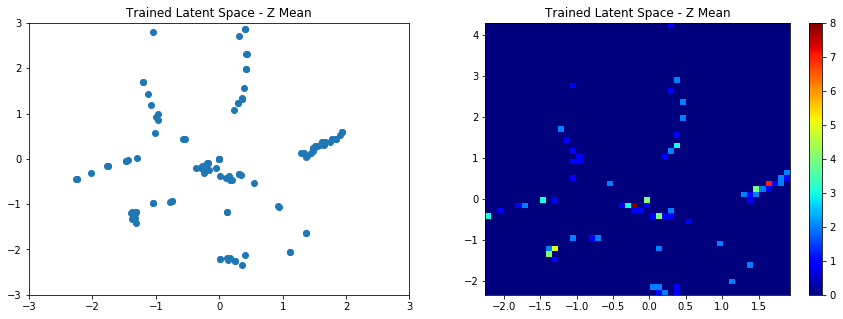

In [2]:
pluginTest = tfPlugin()
pluginTest.onSetup()
pluginTest.onBeginTraining()
pluginTest.onJsonInput({})
pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

In [3]:
json_test = {'damages_first': '26.5',
 'damages_last': '6.25',
 'distances_first': '14.0',
 'distances_last': '21.0',
 'firemode_Automatic': '0.0',
 'firemode_Semi-Automatic': '0.0',
 'firemode_Single-Action': '1.0',
 'hiprecoildec': '6.0',
 'hiprecoilright': '1.2000000476837158',
 'hiprecoilup': '11.0',
 'hipstandbasespreaddec': '4.5',
 'hipstandbasespreadinc': '0.30000001192092896',
 'hordispersion': '2.700000047683716',
 'initialspeed': '333.0',
 'magsize': '2.0',
 'reloadempty': '5.333333492279053',
 'rof': '299.0',
 'shotspershell': '12.0',
 'type_Pistol': '0.0',
 'type_Rifle': '-2.7755575615628914e-17',
 'type_Shotgun': '1.0',
 'type_Sniper Rifle': '0.0',
 'type_Submachine Gun': '0.0',
 'type_Light Machine Gun' : '0.0'}

def input_and_train():
    global pluginTest, json_test
    for _ in range(pluginTest._dismantled_weapons_needed_to_retrain):
        for key, value in json_test.items():
            if "type" not in key or "firemode" not in key:
                new_value = float(value) * np.random.uniform(low=0.8, high=5.2)
                json_test[key] = str(new_value)
        print(pluginTest.onJsonInput(json_test))
    pluginTest.onBeginTraining()
    pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

Generated a random weapon!
{'damages_first': '31.98237404155897', 'damages_last': '19.831682722590493', 'distances_first': '7.832712639037531', 'distances_last': '41.913821531096545', 'firemode_Automatic': '0.0997086980908462', 'firemode_Semi': '0.1265196778858278', 'firemode_Single': '0.043895806332000936', 'hiprecoildec': '3.9765994402640814', 'hiprecoilright': '0.38625259048295246', 'hiprecoilup': '1.2505892606634847', 'hipstandbasespreaddec': '4.3328604871360685', 'hipstandbasespreadinc': '0.15623886079838864', 'initialspeed': '471.351280426978', 'magsize': '5.01185126498337', 'reloadempty': '3.1725441395848275', 'rof': '202.26611413630985', 'shotspershell': '0.32414161471484926', 'type_Shotgun': '-0.057191626222834385', 'type_Pistol': '-0.004511204926675838', 'type_Rifle': '0.010675601036448296', 'type_SMG': '-0.04924638086441942', 'type_Sniper': '0.010675601036448185', 'type_MG': '-0.04608755857562147'}
Generated a random weapon!
{'damages_first': '42.68613487716464', 'damages_la

Generated a random weapon!
{'damages_first': '80.01949582987055', 'damages_last': '66.43581137756425', 'distances_first': '35.253436429177114', 'distances_last': '122.48525587686021', 'firemode_Automatic': '1.0032038763561253', 'firemode_Semi': '1.0471698084393148', 'firemode_Single': '0.8922718385308457', 'hiprecoildec': '9.353282258227994', 'hiprecoilright': '1.1375148744935382', 'hiprecoilup': '6.533967133194267', 'hipstandbasespreaddec': '14.035458511103784', 'hipstandbasespreadinc': '0.9013814657490572', 'initialspeed': '864.6252397850967', 'magsize': '72.92449737850147', 'reloadempty': '5.532060745937953', 'rof': '628.8064185492702', 'shotspershell': '5.682030417171935', 'type_Shotgun': '0.4982008573968081', 'type_Pistol': '0.761628227515692', 'type_Rifle': '0.8077016059526557', 'type_SMG': '0.5635484533782469', 'type_Sniper': '0.807701605952656', 'type_MG': '0.5839724800228872'}
Generated a random weapon!
{'damages_first': '86.38004993965211', 'damages_last': '72.6066240951844',

Generated a random weapon!
Should retrain!
{'damages_first': '32.24309765364001', 'damages_last': '20.08462870079377', 'distances_first': '7.98153983530351', 'distances_last': '42.35112656959886', 'firemode_Automatic': '0.10461245829973628', 'firemode_Semi': '0.13151654736020155', 'firemode_Single': '0.04850040492749144', 'hiprecoildec': '4.005781625064643', 'hiprecoilright': '0.39033009989683143', 'hiprecoilup': '1.2792650287285574', 'hipstandbasespreaddec': '4.3855217688533', 'hipstandbasespreadinc': '0.16028315538236362', 'initialspeed': '473.485792308708', 'magsize': '5.380450168113455', 'reloadempty': '3.185350520764045', 'rof': '204.581180583354', 'shotspershell': '0.3532217941615097', 'type_Shotgun': '-0.05417720885015975', 'type_Pistol': '-0.00035294912891287167', 'type_Rifle': '0.015001495078144161', 'type_SMG': '-0.04592040968420551', 'type_Sniper': '0.015001495078144078', 'type_MG': '-0.042667879731929925'}
Num of training samples = 147
Epoch:0010 - Cost:10.69
Epoch:0020 - C

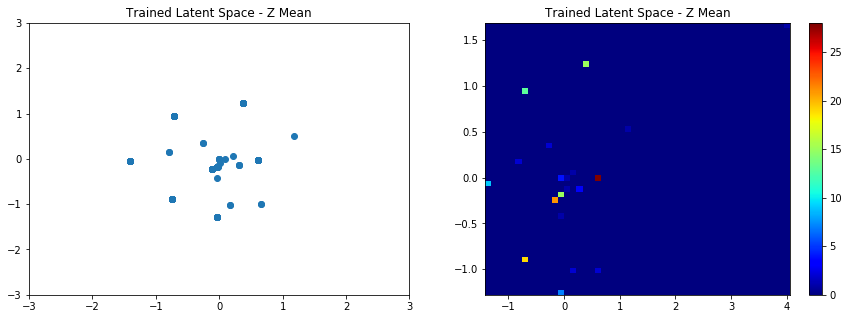

In [4]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '-14139973.60681635', 'damages_last': '-67393197.53095156', 'distances_first': '-796090802.255856', 'distances_last': '-11269207.828156196', 'firemode_Automatic': '0.15023496618756269', 'firemode_Semi': '0.17387016834395277', 'firemode_Single': '0.0994415779711035', 'hiprecoildec': '-292774211.3400329', 'hiprecoilright': '-29474301.409170263', 'hiprecoilup': '-142642266.92350766', 'hipstandbasespreaddec': '-5191988.68054928', 'hipstandbasespreadinc': '-34554.10323617667', 'initialspeed': '-13823564993.102089', 'magsize': '-123833123.47654587', 'reloadempty': '-5404752.585729375', 'rof': '-28179074.16297336', 'shotspershell': '-206230751.48197728', 'type_Shotgun': '-0.007501842732861988', 'type_Pistol': '0.05265757297007331', 'type_Rifle': '0.06773162899792534', 'type_SMG': '0.003498923517698399', 'type_Sniper': '0.0677316289979254', 'type_MG': '0.007456147223251899'}
Generated 

Generated a random weapon!
{'damages_first': '-22578292.626338832', 'damages_last': '-101108862.67214093', 'distances_first': '-1231036587.2842665', 'distances_last': '-17339812.989259664', 'firemode_Automatic': '0.101286264986092', 'firemode_Semi': '0.1237474705685227', 'firemode_Single': '0.05391769945828745', 'hiprecoildec': '-450803898.2241181', 'hiprecoilright': '-44592380.3133215', 'hiprecoilup': '-214865687.17202234', 'hipstandbasespreaddec': '-7811381.466040594', 'hipstandbasespreadinc': '-54571.695832874844', 'initialspeed': '-21268572097.274075', 'magsize': '-185862512.29593062', 'reloadempty': '-8610112.742559351', 'rof': '-44257803.56768507', 'shotspershell': '-312310024.1583344', 'type_Shotgun': '-0.036767193205386586', 'type_Pistol': '0.011874909906457148', 'type_Rifle': '0.025197629188962595', 'type_SMG': '-0.028855138774173034', 'type_Sniper': '0.02519762918896265', 'type_MG': '-0.02583217152496463'}
Generated a random weapon!
{'damages_first': '-3991364.2219129205', 'd

Generated a random weapon!
{'damages_first': '-19331563.281966753', 'damages_last': '-88136416.48639375', 'distances_first': '-1063686758.4622457', 'distances_last': '-15004085.71122573', 'firemode_Automatic': '0.12011977722852307', 'firemode_Semi': '0.14303268997182877', 'firemode_Single': '0.0714334762255841', 'hiprecoildec': '-390000363.71665823', 'hiprecoilright': '-38775545.19544065', 'hiprecoilup': '-187076989.28927287', 'hipstandbasespreaddec': '-6803543.3644689815', 'hipstandbasespreadinc': '-46869.72282888868', 'initialspeed': '-18404029647.735157', 'magsize': '-161996072.02181566', 'reloadempty': '-7376817.715862212', 'rof': '-38071348.367577', 'shotspershell': '-271494941.6008767', 'type_Shotgun': '-0.025507050997838746', 'type_Pistol': '0.02756645565199531', 'type_Rifle': '0.041563019617291086', 'type_SMG': '-0.0164065831780129', 'type_Sniper': '0.04156301961729117', 'type_MG': '-0.013024151224404604'}
Generated a random weapon!
Should retrain!
{'damages_first': '-29191357.

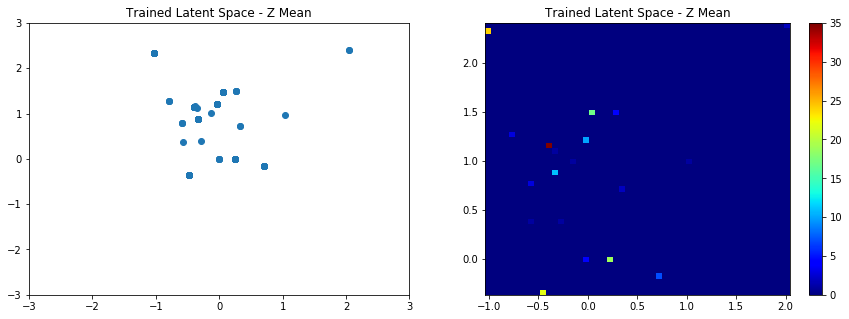

In [5]:
input_and_train()

In [6]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '1.8629681383332024e+16', 'damages_last': '5.522268376851714e+16', 'distances_first': '2.5479222214969364e+18', 'distances_last': '2.0289379060016307e+17', 'firemode_Automatic': '0.3835281546563598', 'firemode_Semi': '0.4107628430458474', 'firemode_Single': '0.32050412017013785', 'hiprecoildec': '1.5506512377149773e+18', 'hiprecoilright': '1.4058451927721965e+17', 'hiprecoilup': '6.783515555149595e+16', 'hipstandbasespreaddec': '1055897730843939.8', 'hipstandbasespreadinc': '16453146949629.975', 'initialspeed': '1.4029341972277433e+20', 'magsize': '3.364823486525284e+16', 'reloadempty': '872811826499741.1', 'rof': '3632958642370810.0', 'shotspershell': '1.7956510740679654e+18', 'type_Shotgun': '0.14223773496265069', 'type_Pistol': '0.2544979524076424', 'type_Rifle': '0.27689085680079145', 'type_SMG': '0.1677439840033843', 'type_Sniper': '0.2768908568007915', 'type_MG': '0.17602

KeyboardInterrupt: 

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
pluginTest.onJsonInput(json_test)